In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [23]:
# Preprocessing Layer: Normalize Pixel Values (0-1)
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "banana_dataset",  # Use the path to the extracted folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

# Verify the dataset
for images, labels in dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)


Found 6188 files belonging to 4 classes.
Batch shape: (32, 256, 256, 3)
Labels shape: (32,)


In [4]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Healthy Leaf',
 'Banana Panama Disease',
 'UnKnown']

In [5]:
len(dataset)

194

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 3 3 1 3 1 1 1 2 2 0 3 1 3 3 1 3 2 0 0 0 2 1 1 2 2 0 2 3 0 1]


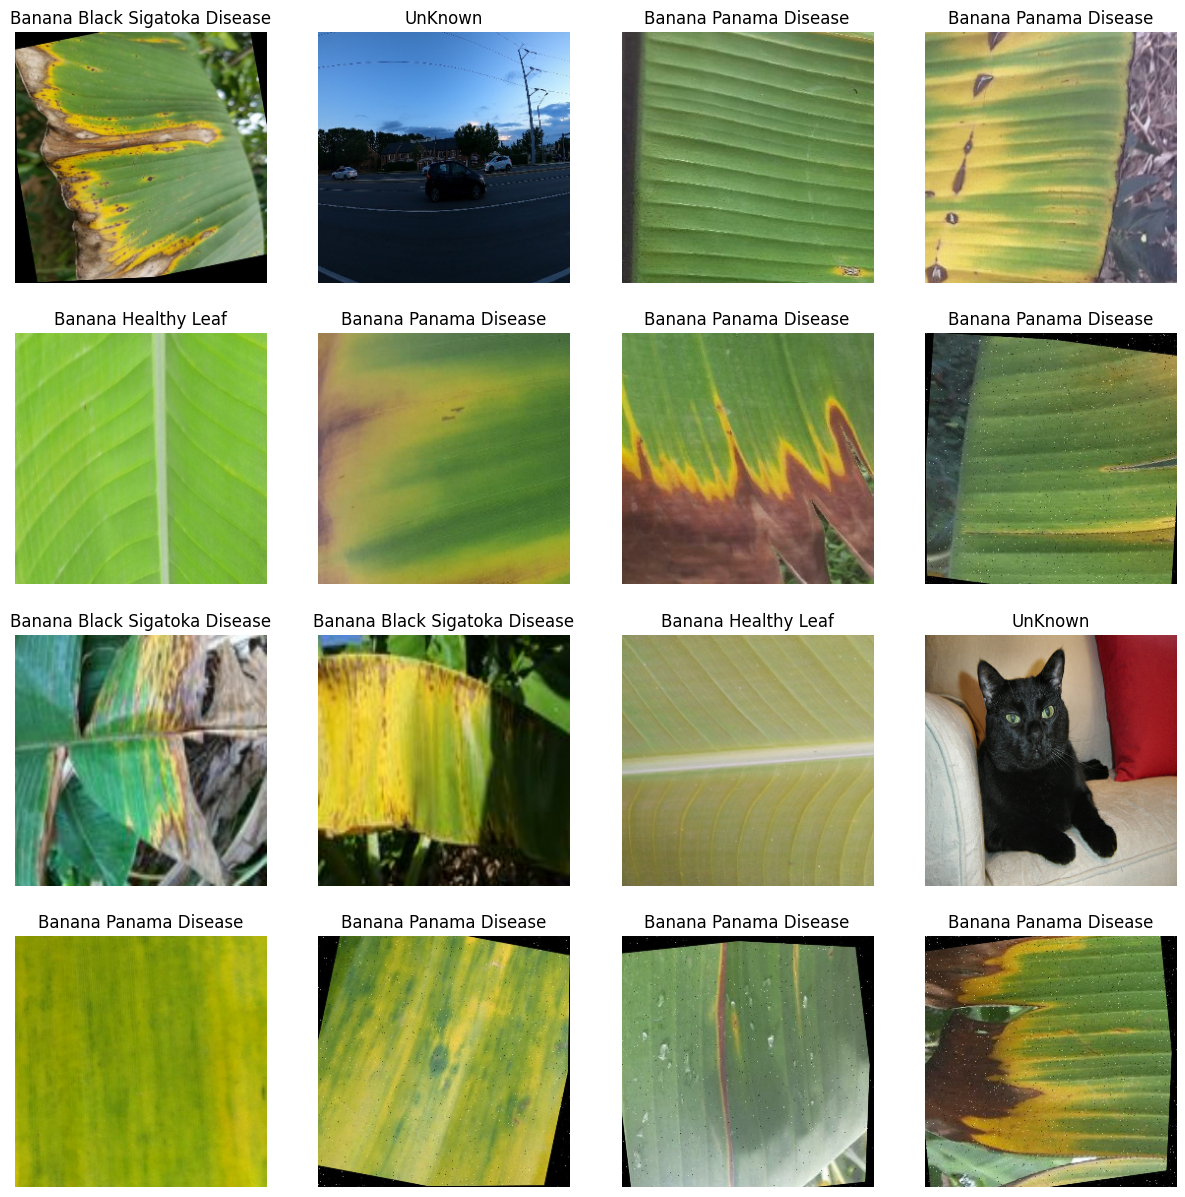

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

194

In [9]:
train_size = 0.8
len(dataset)*train_size

155.20000000000002

In [10]:
test_ds = dataset.skip(82)
len(test_ds)


112

In [11]:
val_size=0.1
len(dataset)*val_size

19.400000000000002

In [12]:
val_ds = test_ds.take(10)
len(val_ds)


10

In [13]:
test_ds = test_ds.skip(10)
len(test_ds)

102

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


In [28]:
print(model.output_shape)  # Should be (None, 4)


(None, 3)


In [29]:
# Model Definition
model = models.Sequential([
    resize_and_rescale,  # Rescaling Layer First
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

# Build the Model
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [30]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',  # Specifies the optimizer to use
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Specifies the loss function
    metrics=['accuracy']  # Specifies the metrics to monitor during training
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.3951 - loss: 1.2252 - val_accuracy: 0.5724 - val_loss: 0.8656
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 86s 556ms/step - accuracy: 0.6289 - loss: 0.8400 - val_accuracy: 0.7039 - val_loss: 0.7146
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 94s 605ms/step - accuracy: 0.6963 - loss: 0.7280 - val_accuracy: 0.7681 - val_loss: 0.6306
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 95s 614ms/step - accuracy: 0.7920 - loss: 0.5487 - val_accuracy: 0.8339 - val_loss: 0.4377
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 97s 625ms/step - accuracy: 0.8181 - loss: 0.4805 - val_accuracy: 0.8454 - val_loss: 0.3783
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 99s 638ms/step - accuracy: 0.8399 - loss: 0.4131 - val_accuracy: 0.8438 - val_loss: 0.4236
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 98s 633ms/step - accuracy: 0.8453 - loss: 0.4044 - val_accuracy: 0.8668 - val_loss: 0.3489
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 100s 643ms/step - accuracy: 0.8758 - loss: 

In [33]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 332ms/step - accuracy: 0.9541 - loss: 0.1626


In [34]:
scores

[0.1559094339609146, 0.949999988079071]

In [35]:
history.history['loss'][:5]


[1.0954381227493286,
 0.8266483545303345,
 0.6591578722000122,
 0.5320147275924683,
 0.47605326771736145]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

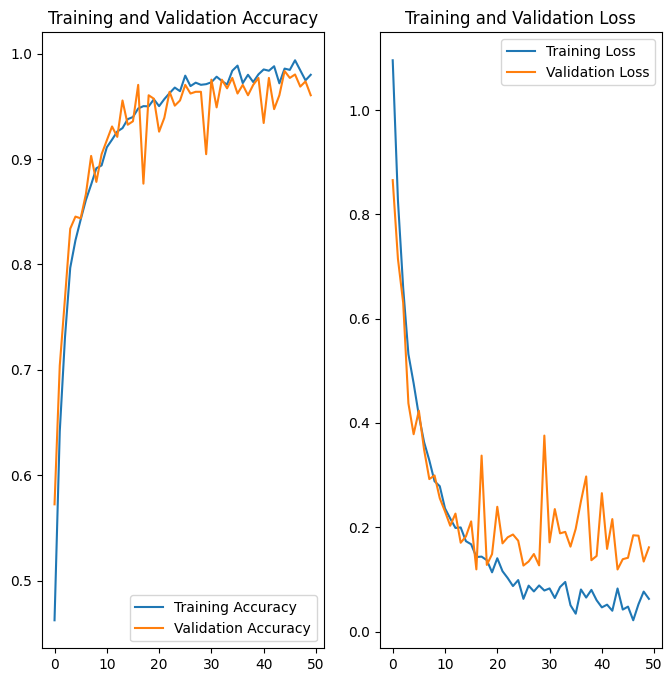

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

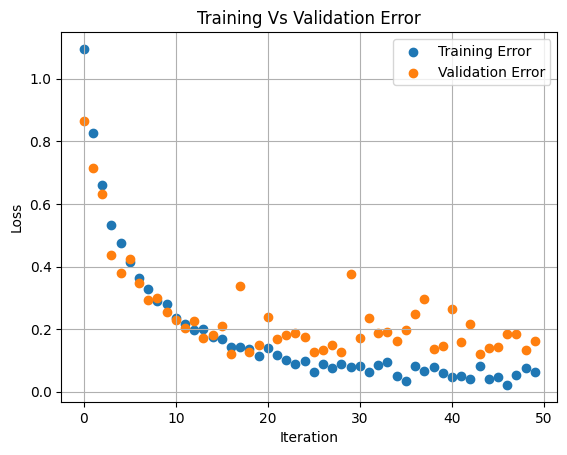

In [38]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

first image to predict
actual label: UnKnown
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
predicted label: UnKnown


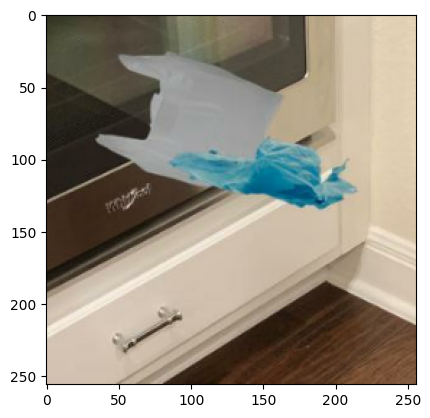

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


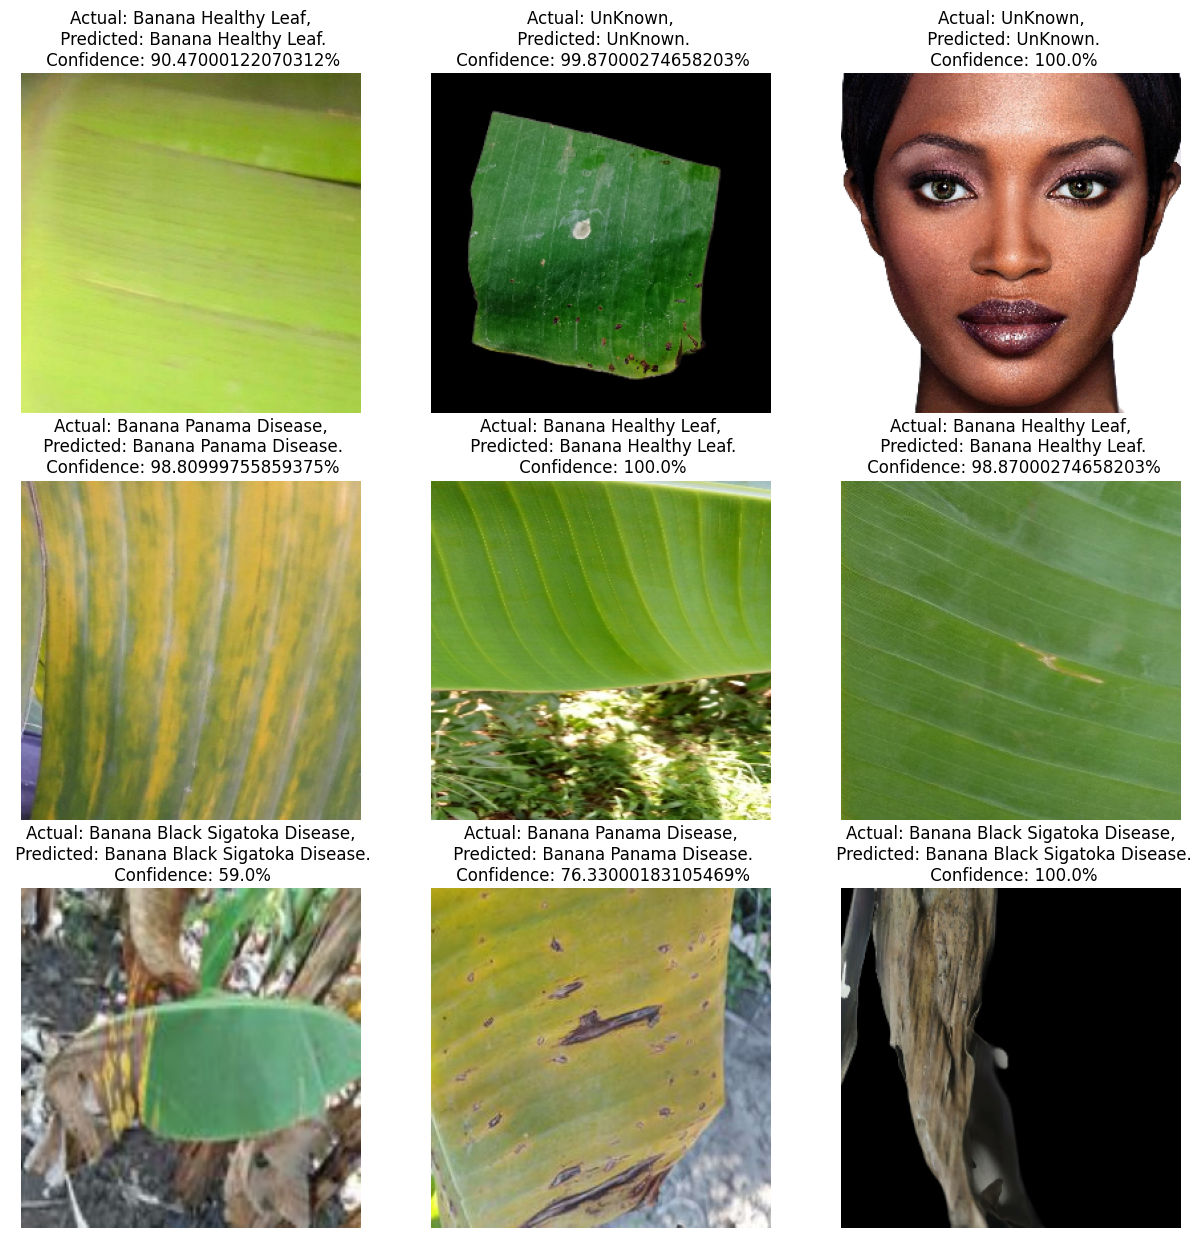

In [40]:
import numpy as np

def predict(model, image):
    """
    Predicts the class of an image using the given model.

    Args:
        model: The trained Keras model.
        image: The image to predict.

    Returns:
        A tuple containing the predicted class name and confidence score.
    """
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    confidence = round(100 * (np.max(prediction)), 2)
    predicted_class = class_names[predicted_class_index]

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy()) # Call the defined 'predict' function
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [43]:
# Define the models directory
models_dir = "../saved_models/6"

# Ensure the directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model.save(f"{models_dir}/banana.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
